In [1]:
import geopandas as gpd
import pandas as pd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import pyproj
import fiona
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read inspire Ag PV data
agv_df = pd.read_csv('result.csv')

# the coordinates column is read as a string separated by ','. Convert it into a tuple of floats
def convert_coordinates(coord: str) -> tuple:
    """Takes a lat, lon str and converts it to a tuple of floats"""
    tup = tuple(float(c) for c in re.split(r'\,\s*', coord))
    
    # the county line df has flipped lat, long coordinates relative to these
    return tup[1], tup[0]

# drop any rows where coordinates are nan
agv_df = agv_df.dropna(subset=['Coordinates'])
agv_df['Coordinates'] = agv_df['Coordinates'].apply(convert_coordinates)
    
agv_df.head()

,Name,Agrivoltaic Activities,Coordinates,System Size,Site Size,Year Installed,PV Technology,Type Of Array,Habitat Type,Crop Types,Animal Type,Research Ongoing,Research Site,State,Developer,Owner
0,InSPIRE/Sites/Abel,Habitat,"(-90.036077, 41.843493)",2.4,17.0,NaN,NaN,NaN,Pollinator,NaN,NaN,No,No,IL,NaN,Engie
1,InSPIRE/Sites/Acturus Community Solar,Habitat,"(-93.95420579660917, 44.284053349833094)",1.5,7.6,2018.0,NaN,Fixed,Native grasses,NaN,NaN,NaN,No,MN,National Grid Renewables,National Grid Renewables
2,InSPIRE/Sites/Agard-enfield,Grazing,"(-76.5947, 42.4543)",2.3,4.5,2017.0,Monofacial PV,Fixed,NaN,NaN,Sheep,NaN,NaN,NY,Enfield Community Solar,Unknown
3,InSPIRE/Sites/Agawam,Habitat,"(-72.61378633278119, 42.082634601099734)",1.8,9.0,2012.0,NaN,Fixed,Pollinator,NaN,NaN,No,No,MA,Citizens Enterprises Corporation,Unknown
4,InSPIRE/Sites/Albany,"Habitat,Grazing","(-94.599251, 45.641268)",15.2,100.8,2016.0,Monofacial PV,Single-axis Tracking,Pollinator,NaN,Sheep,NaN,NaN,MN,"Enel Green Power NA, Inc.",Unknown


In [3]:
# load a shapefile of US county boudnaries
county_zipfile = 'zip://cb_2023_us_county_20m.zip'
county_gdf = gpd.read_file(county_zipfile)
county_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,13,027,00345518,0500000US13027,13027,Brooks,Brooks County,GA,Georgia,06,1277341276,11955761,"POLYGON ((-83.73616 31.03768, -83.57396 31.033..."
1,31,095,00835869,0500000US31095,31095,Jefferson,Jefferson County,NE,Nebraska,06,1476765697,14202851,"POLYGON ((-97.36869 40.35039, -96.91606 40.349..."
2,51,683,01498430,0500000US51683,51683,Manassas,Manassas city,VA,Virginia,25,25493247,146287,"POLYGON ((-77.52666 38.73320, -77.49545 38.770..."
3,56,021,01605075,0500000US56021,56021,Laramie,Laramie County,WY,Wyoming,06,6956355036,4348083,"POLYGON ((-105.27824 41.65666, -104.65334 41.6..."
4,13,135,01688166,0500000US13135,13135,Gwinnett,Gwinnett County,GA,Georgia,06,1116606767,15938345,"POLYGON ((-84.27117 33.95980, -84.26265 33.987..."


In [6]:
# agrivoltaic sites are in lat lon, but other environmental data is by county FIPS. 
# Do a spatial join to find the site in which each county resides
geometry = agv_df['Coordinates'].apply(Point)
crs = {'init' :'epsg:4269'}
agv_gdf = gpd.GeoDataFrame(agv_df, geometry=geometry)
agv_gdf.crs = county_gdf.crs

county_agv_gdf = gpd.sjoin(county_gdf, agv_gdf, how='inner', op='contains')

county_agv_gdf = county_agv_gdf.rename(columns={'GEOID':'FIPS'})
county_agv_gdf['FIPS'] = county_agv_gdf['FIPS'].apply(lambda x: x.zfill(5))

# agrivoltaic activites are str of comma delimited categories. Let's convert them to a column of list entries so they can be exploded
county_agv_gdf['Agrivoltaic Activities'] = county_agv_gdf['Agrivoltaic Activities'].apply(lambda x: x.split(','))

county_agv_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,FIPS,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,...,PV Technology,Type Of Array,Habitat Type,Crop Types,Animal Type,Research Ongoing,Research Site,State,Developer,Owner
22,13,161,01687999,0500000US13161,13161,Jeff Davis,Jeff Davis County,GA,Georgia,06,...,Other,Single-axis Tracking,NaN,NaN,Sheep,NaN,No,GA,"SR Snipesville II, LLC",Silicon Ranch
22,13,161,01687999,0500000US13161,13161,Jeff Davis,Jeff Davis County,GA,Georgia,06,...,NaN,NaN,NaN,NaN,Sheep,NaN,No,GA,Unknown,Silicon Ranch
22,13,161,01687999,0500000US13161,13161,Jeff Davis,Jeff Davis County,GA,Georgia,06,...,NaN,Single-axis Tracking,NaN,NaN,Sheep,NaN,No,GA,"SR South Loving, LLC",Silicon Ranch
22,13,161,01687999,0500000US13161,13161,Jeff Davis,Jeff Davis County,GA,Georgia,06,...,NaN,Single-axis Tracking,NaN,NaN,Sheep,NaN,No,GA,"SR Snipesville, LLC",Silicon Ranch
40,27,121,00659506,0500000US27121,27121,Pope,Pope County,MN,Minnesota,06,...,NaN,Single-axis Tracking,Pollinator,NaN,NaN,NaN,No,MN,USS,USS


In [7]:
"""
U.S. Department of Energy, Office of Energy Efficiency and Renewable Energy. (2020). Low-Income Energy Affordability Data - LEAD Tool - 2018 Update [data set].  Retrieved from https://dx.doi.org/10.25984/1784729.
"""
def clean_fips(fips) -> str:
    '''Takes a fips code and zfills it to 5 digits'''
    return str(fips).zfill(5)

# Need new data path
# first 8 rows of LEAD tool data are meta data. skip those rows
energy_burden_df = pd.read_csv('LEAD Tool Data Counties.csv', skiprows=range(8))
energy_burden_df['Geography ID'] = energy_burden_df['Geography ID'].apply(clean_fips)
energy_burden_df = energy_burden_df.rename(columns={'Geography ID': 'FIPS'})

# Simplify racial demographic data to white vs non white
energy_burden_df['Non-White (% pop.)'] = 100 - energy_burden_df['White Non-Hispanic or Latino (% pop.)']

keep_cols = ['FIPS', 'Energy Burden (% income)', 'Avg. Annual Energy Cost ($)', 'Non-White (% pop.)']
energy_burden_df = energy_burden_df[keep_cols]


# Get some high level stats on energy Energy Burdens
energy_burden_df.describe()

,Energy Burden (% income),Avg. Annual Energy Cost ($),Non-White (% pop.)
count,3221.000000,3221.000000,3221.000000
mean,3.235331,2214.876125,26.011798
std,1.066372,632.966806,23.110789
min,1.000000,706.000000,0.000000
25%,3.000000,1862.000000,8.000000
50%,3.000000,2110.000000,18.000000
75%,4.000000,2443.000000,38.000000
max,13.000000,12887.000000,100.000000


In [8]:
"""
National Risk index

https://hazards.fema.gov/nri/expected-annual-loss

"""

nri_df = pd.read_csv('NRI_Table_Counties//NRI_Table_Counties_Scores.csv')
nri_df['STCOFIPS'] = nri_df['STCOFIPS'].apply(clean_fips)
nri_df = nri_df.rename(columns={'STCOFIPS':'FIPS'})

# Keep columns related to risk. Risk captures expectd losses * social vulnerabilty / community resilieince
nri_df = nri_df[['FIPS', 'RISK_VALUE', 'RISK_SCORE', 'RISK_RATNG']]

# how mnay of each risk rating do we have?
display(nri_df['RISK_RATNG'].value_counts())


nri_df.describe()

Very Low               1511
Relatively Low         1091
Relatively Moderate     397
Relatively High         129
Insufficient Data        88
Very High                15
Name: RISK_RATNG, dtype: int64

,RISK_VALUE,RISK_SCORE
count,3.143000e+03,3143.000000
mean,2.784074e+07,50.015908
std,1.394166e+08,28.872105
min,3.574127e+04,0.031817
25%,3.142512e+06,25.023863
50%,6.290127e+06,50.015908
75%,1.543971e+07,75.007954
max,5.326193e+09,100.000000


In [9]:
# merge all data together. Use right joins to preserve the EEEJ data in counties that have no agrivoltaics
merged_df = county_agv_gdf.merge(energy_burden_df, on='FIPS', how='right')
merged_df = merged_df.merge(nri_df, on='FIPS', how='right')
merged_df.describe()

,ALAND,AWATER,index_right,System Size,Site Size,Year Installed,Energy Burden (% income),Avg. Annual Energy Cost ($),Non-White (% pop.),RISK_VALUE,RISK_SCORE
count,5.120000e+02,5.120000e+02,512.000000,512.000000,512.000000,485.000000,3522.000000,3522.000000,3522.000000,3.444000e+03,3444.000000
mean,2.602050e+09,1.103885e+08,258.593750,17.881290,111.465139,2018.853608,3.181147,2222.589722,25.321692,2.786352e+07,51.525661
std,4.235517e+09,3.155790e+08,150.604142,57.516446,375.339422,2.408064,1.062440,621.741605,22.601637,1.339536e+08,28.684183
min,4.489887e+07,1.310800e+05,0.000000,0.004800,0.008000,2009.000000,1.000000,706.000000,0.000000,3.574127e+04,0.031817
25%,1.153403e+09,1.763524e+07,128.750000,1.400000,7.900000,2017.000000,3.000000,1869.250000,8.000000,3.327735e+06,27.195355
50%,1.624527e+09,4.662589e+07,257.500000,2.600000,12.000000,2019.000000,3.000000,2125.000000,17.000000,6.705119e+06,52.608972
75%,2.275494e+09,7.833229e+07,388.250000,6.500000,31.000000,2021.000000,4.000000,2444.000000,36.000000,1.672585e+07,76.431753
max,6.399163e+10,4.054462e+09,520.000000,752.100000,4700.000000,2024.000000,13.000000,12887.000000,100.000000,5.326193e+09,100.000000


# Data Visualization and Analysis
## What is the state of agrivoltaics in the USA? (pun intended)
Let's explore the data a little bit. Which states have the most agrivoltaic activity? We can approach that 2 ways:
* Where is the most power being generated?
* Where are the most sites?

Text(0.5, 0, 'Ag PV Site count')

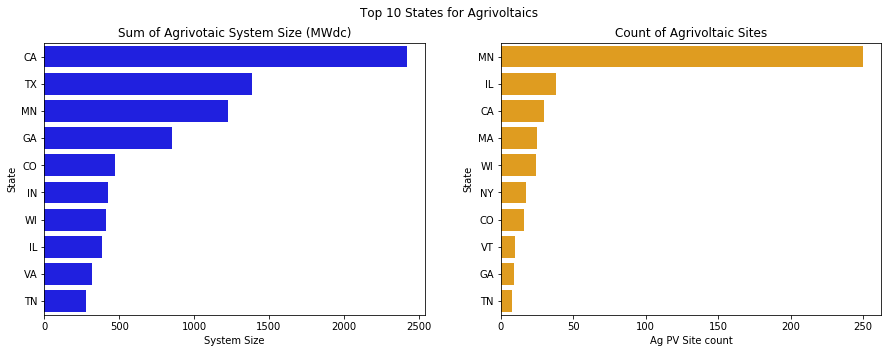

In [10]:
# which states generate the most energy
sum_df = merged_df.groupby('State', as_index=False).sum()
sum_df = sum_df.sort_values('System Size', ascending=False)

# which states have the most sites
count_df = merged_df.groupby('State', as_index=False).count()
count_df = count_df.sort_values('System Size', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Top 10 States for Agrivoltaics')


sns.barplot(data=sum_df.head(10), x='System Size', y='State', ax=axes[0], color='b')
axes[0].set_title('Sum of Agrivotaic System Size (MWdc)')

sns.barplot(data=count_df.head(10), x='System Size', y='State', ax=axes[1], color='orange')
axes[1].set_title('Count of Agrivoltaic Sites')
axes[1].set_xlabel('Ag PV Site count')



## Observation
Interesting: California generates the most power, but Minnesota has the most sites (and 2nd place isn't close). MN has nearly 10x the sites as the next closest state.

California likely has much bigger operations than MN.

What about types of agrivoltaic activity? Are solar panels being paired with crops, or is it with other plant life?

Text(0.5, 1.0, 'Histogram of Agrivotaic Activity Types')

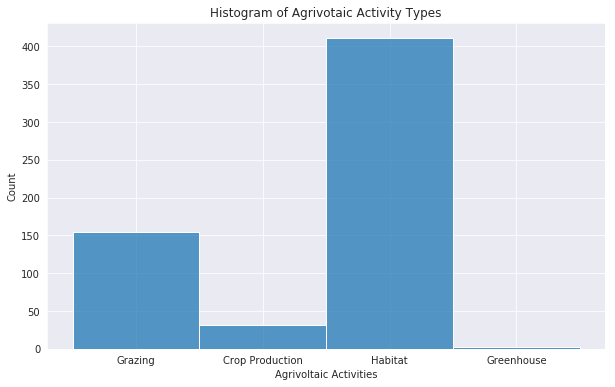

In [52]:
viz_cols = ['System Size', 'Site Size', 'Energy Burden (% income)', 'RISK_VALUE', 'Non-White (% pop.)', 'Agrivoltaic Activities']
viz_df = merged_df.loc[:, viz_cols].explode('Agrivoltaic Activities', ignore_index=True)

# histogram of different agv types
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))
g = sns.histplot(viz_df, x='Agrivoltaic Activities', ax=ax)
g.set_title('Histogram of Agrivotaic Activity Types')

# Observations
Most of the activity is towards Habitat and Grazing. Crop production only has ~25 sites. More sites in crop production could create more diversification in farmer income streams, but there might be something about the technology right now that precludes combining solar panels and crops at a large scale.

## Combining Agrivolatics and EEEJ data
Let's look more at agrivoltaics from a EEEJ perspective. Are there any major trends with the social data?

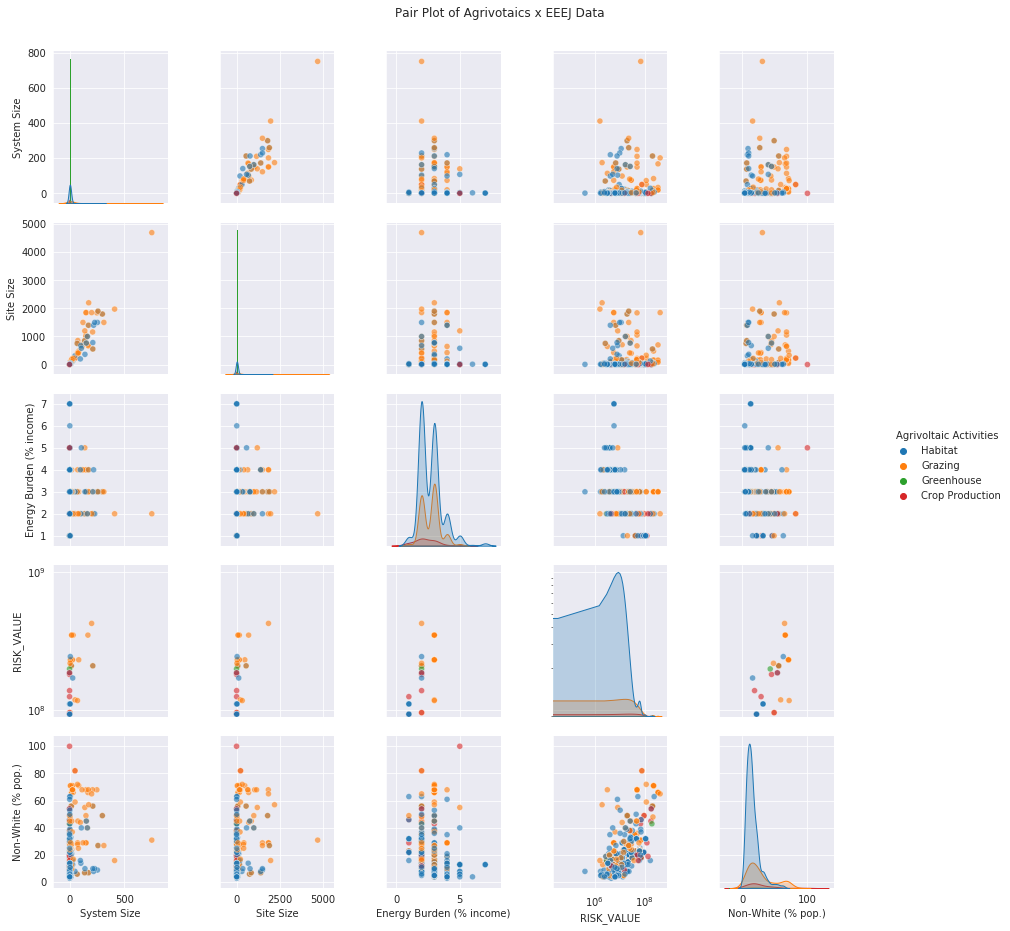

In [53]:
g = sns.pairplot(data=viz_df, plot_kws={'alpha': 0.6}, hue='Agrivoltaic Activities',
                 hue_order=['Habitat', 'Grazing', 'Greenhouse', 'Crop Production'])

g.fig.suptitle('Pair Plot of Agrivotaics x EEEJ Data', y=1.03)

# put risk value on a log scale
for ax in g.axes.flat:
    if ax.get_xlabel() == 'RISK_VALUE':
        ax.set(xscale="log")
    if ax.get_ylabel() == 'RISK_VALUE':
        ax.set(yscale='log')
        

# Observations
* Energy Output (system size) is positively correlated with site size. This makes intuitive sense: more area can fit more solar panels, hence more energy generated.
* Sadly, there also seems to be a correlation with non-white populations and risk of agricultural loss. This is not surprising, since minority communities often bear disproportionate effects of climate change.
* There are some sites that have both high energy burdens and relatively large system sizes. These sites might be candidates for further investment to use agrivoltaics to lower the energy burden.
* There could be some interesting opportuntites in system size vs agrivultural loss risk. It would be interesting to see what trends emerge after filtering out the low system size sites.
    * Agrivoltaics could be an attractive option for sites with high risk of agricultural loss if the income from power generation could mitigate potential crop losses due to climate change. However, the solar panel systems would need to be resilient to the specific climate hazards in each region. Thsi would be an interesting future area of research.

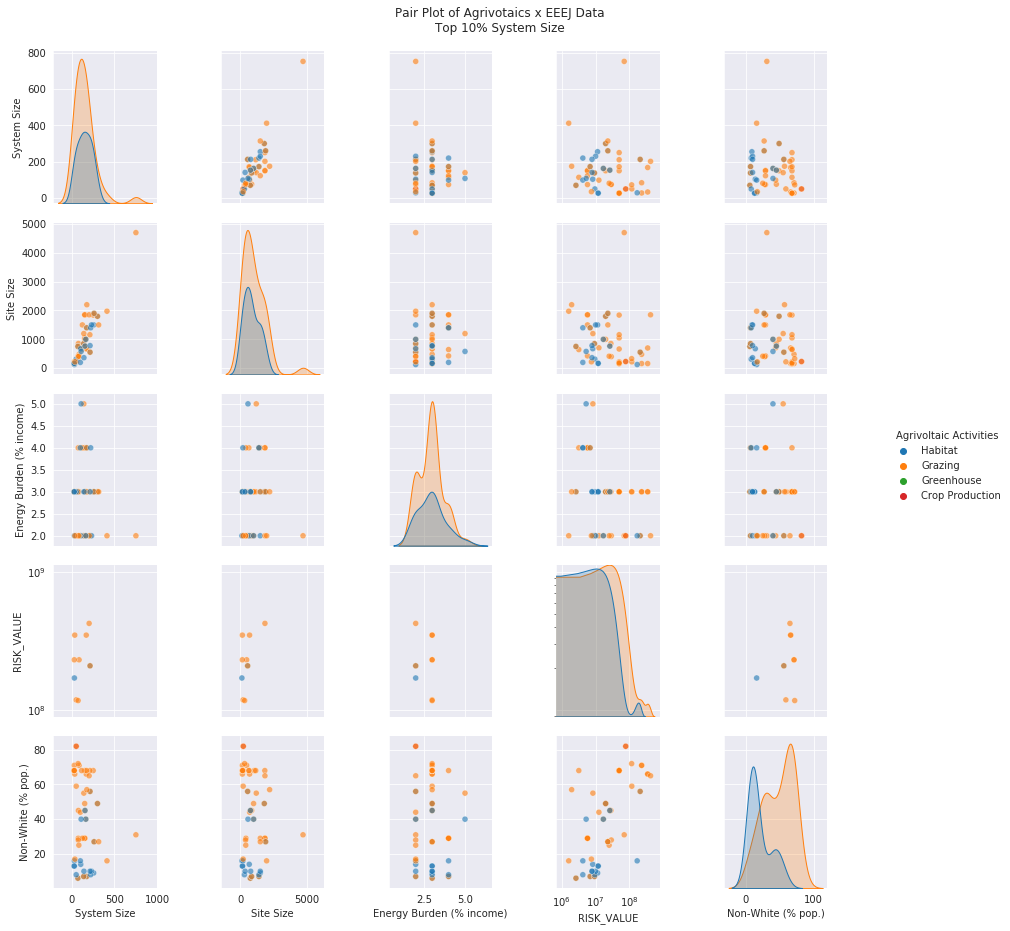

In [57]:
# Plot Just top 10% of system size

thresh = merged_df['System Size'].quantile(0.9)

g = sns.pairplot(viz_df.loc[viz_df['System Size'] > thresh, :], hue='Agrivoltaic Activities', plot_kws={'alpha': 0.6}, 
                 hue_order=['Habitat', 'Grazing', 'Greenhouse', 'Crop Production'])

g.fig.suptitle('Pair Plot of Agrivotaics x EEEJ Data\nTop 10% System Size', y=1.03)

# put risk value on a log scale
for ax in g.axes.flat:
    if ax.get_xlabel() == 'RISK_VALUE':
        ax.set(xscale="log")
    if ax.get_ylabel() == 'RISK_VALUE':
        ax.set(yscale='log')